In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
import copy

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,SAMEA4431948,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431948,SZAXPI029564-74,SZAXPI029564-74,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,52212493.0,Unhealthy
4343,SAMEA4431949,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431949,SZAXPI029565-77,SZAXPI029565-77,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,50635879.0,Unhealthy
4344,SAMEA4431951,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431951,SZAXPI029567-80,SZAXPI029567-80,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,40712962.0,Unhealthy
4345,SAMEA4431964,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431964,SZAXPI029580-98,SZAXPI029580-98,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,38177360.0,Unhealthy


In [6]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Run PCA

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(MatrixData)

In [8]:
# Do all principal components
pca_model = PCA(n_components = None)

In [9]:
X_PCA = pca_model.fit_transform(X_scaled)

In [10]:
X_PCA.shape

(4347, 903)

<AxesSubplot:>

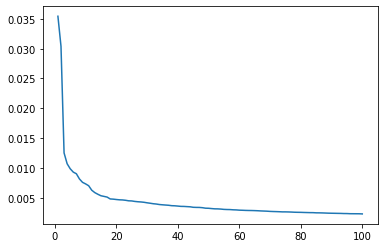

In [11]:
sns.lineplot(x = np.arange(1,101), y = pca_model.explained_variance_ratio_[0:100])

<AxesSubplot:>

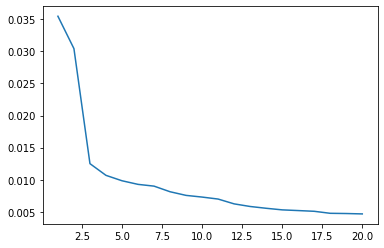

In [12]:
sns.lineplot(x = np.arange(1,21), y = pca_model.explained_variance_ratio_[0:20])

In [13]:
# get median absolute deviation of components to see where variance is not affected by outliers
mad_vals = np.array([stats.median_absolute_deviation(X_PCA[:, i]) for i in range(X_PCA.shape[1])])

/root/anaconda/envs/microbiome/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  


<AxesSubplot:>

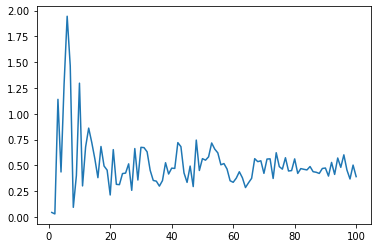

In [14]:
sns.lineplot(x = np.arange(1,101), y = mad_vals[0:100])

In [15]:
mad_ordered_PCs = np.argsort(-mad_vals)
mad_ordered_PCs

array([  5,   6,   9,   4,   2,  12,  47,  13,  41,  52,  16,  42,  11,
        29,  30,  27,  53,  20,  31,  73,  54, 161, 140, 170, 138,  95,
       153, 419, 209, 151, 124, 187, 206, 185, 448, 383,  51, 362, 180,
       199, 426, 197,  76, 160, 409, 356,  93, 190, 424, 220, 393, 408,
       226, 375, 379, 182,  49, 105, 171,  66, 194,  14,  71, 454, 359,
        79, 211, 198, 411, 430,  70, 433, 166, 447, 184, 178, 371, 396,
       432, 403, 397, 177, 164, 400, 421, 373, 416, 125, 167, 441, 205,
       174, 142,  50, 378, 222, 101, 363, 451, 369, 204, 215, 412, 414,
       345, 214, 186, 402,  68, 193, 168, 360, 169, 367, 195, 354, 450,
       449, 368, 202, 423, 422, 398, 189, 353, 431, 343, 374, 188, 149,
        67, 427, 144, 392, 229, 391, 461, 137, 148, 350, 175, 332, 340,
       361, 470, 381, 152, 428, 370, 119, 346, 227, 213, 176, 377,  91,
       401, 390, 372, 155, 365, 181, 388,  37, 349, 425, 465, 141, 165,
       410, 134, 380, 389, 348, 474, 110, 347, 344, 399, 216, 47

In [16]:
mad_vals.shape

(903,)

<AxesSubplot:>

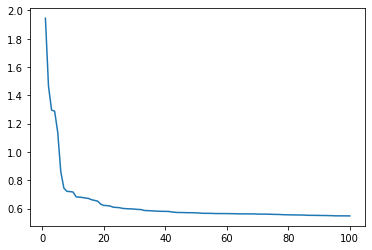

In [17]:
sns.lineplot(x = np.arange(1,101), y = mad_vals[mad_ordered_PCs[0:100]])

In [18]:
pca_model.components_.shape

(903, 903)

In [19]:
heatmap_df = FeatMeta
for i in range(21):
    pc_use = mad_ordered_PCs[i]
    PC_name = 'PC' + str(pc_use)
    heatmap_df[PC_name] = pca_model.components_[pc_use,:]

heatmap_df.index = heatmap_df['feature']
heatmap_df.pop('Unnamed: 0')
heatmap_df.pop('feature')
heatmap_df

,PC5,PC6,PC9,PC4,PC2,PC12,PC47,PC13,PC41,PC52,...,PC42,PC11,PC29,PC30,PC27,PC53,PC20,PC31,PC73,PC54
feature,,,,,,,,,,,,,,,,,,,,,
s__Abiotrophia_defectiva,-0.025062,0.004290,0.014249,-0.014630,0.119335,0.080981,0.053792,0.066800,0.026471,-0.016661,...,0.057729,-0.054866,-0.008851,0.030023,-0.057748,-0.044963,0.018141,-0.014801,-0.014277,-0.042569
s__Acetobacter_unclassified,0.000635,-0.002004,0.003365,-0.000348,-0.001725,-0.002481,0.001992,0.002850,0.000305,0.006688,...,-0.005013,0.001341,-0.003785,-0.003058,-0.007850,0.014423,-0.002767,-0.000689,0.024157,-0.007548
s__Achromobacter_piechaudii,-0.001219,-0.003584,0.004507,-0.005678,0.011605,-0.017313,0.006734,-0.003962,0.007235,-0.074986,...,0.076336,0.005903,-0.163474,0.280874,0.035628,-0.021450,-0.001724,-0.048276,-0.015821,-0.053590
s__Achromobacter_unclassified,0.000692,-0.010150,0.001489,-0.008397,0.006203,0.003479,0.001007,-0.004670,-0.005885,-0.028583,...,0.027234,-0.002523,-0.053337,0.110496,0.022494,-0.006814,0.011198,-0.015896,-0.006758,-0.027825
s__Achromobacter_xylosoxidans,-0.001219,-0.003584,0.004507,-0.005678,0.011605,-0.017313,0.006734,-0.003962,0.007235,-0.074986,...,0.076336,0.005903,-0.163474,0.280874,0.035628,-0.021450,-0.001724,-0.048276,-0.015821,-0.053590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s__Weissella_koreensis,0.000764,-0.002625,0.003949,-0.000383,0.003063,-0.012832,-0.010516,0.006455,0.013703,-0.016380,...,0.003656,0.013887,0.007952,-0.004963,0.007987,0.027889,-0.001787,0.001979,0.004033,-0.003161
s__Weissella_paramesenteroides,-0.017666,0.006672,0.009106,-0.004923,0.037396,-0.025086,-0.078004,-0.024873,0.021381,-0.047896,...,-0.036874,-0.003700,0.033575,-0.055784,0.067814,0.052404,0.042047,-0.059484,-0.023081,0.003582
s__Weissella_unclassified,0.007501,-0.008050,-0.013826,-0.008119,0.015101,0.002022,-0.001491,-0.000673,0.028477,0.026273,...,-0.016939,0.001111,0.015895,0.020571,0.015407,0.040892,0.000398,-0.004498,-0.039057,0.038083


/root/anaconda/envs/microbiome/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


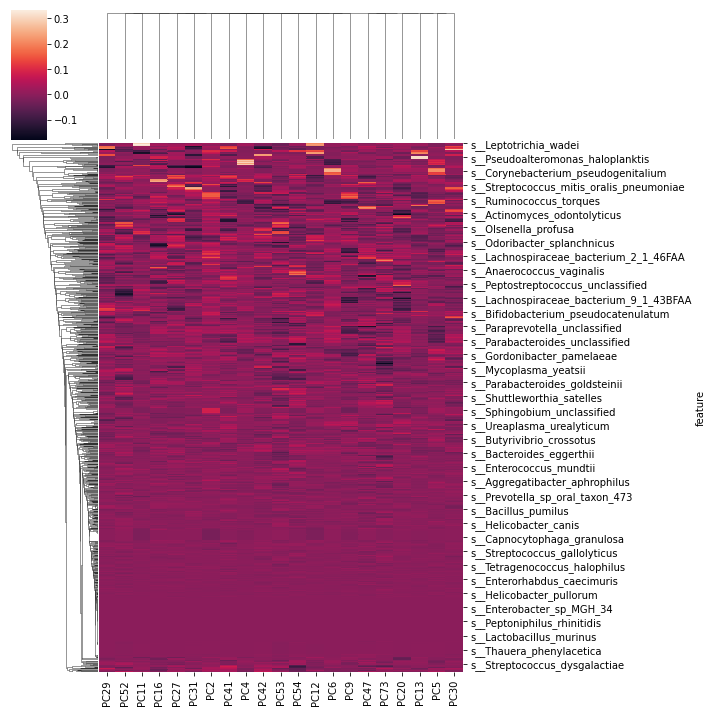

In [20]:
sns.clustermap(heatmap_df)

Overall, we don't see super blocky structure

In [21]:
# get maximum PC loading
max_loading = np.array([np.max(pca_model.components_[mad_ordered_PCs[0:20], i]) for i in range(pca_model.components_.shape[1])])

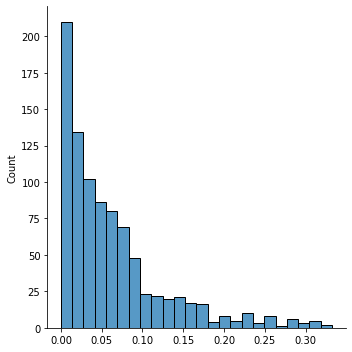

In [22]:
# distribution of maximum PC loadings across ~900 features
sns.displot(max_loading)

It seems like most features are at least somewhat important, while there are a handful that are really important to variation

In [24]:
heatmap_df['PC5'].sort_values(ascending = False)[0:40]

feature
s__Corynebacterium_aurimucosum                  0.212377
s__Peptoniphilus_timonensis                     0.211990
s__Corynebacterium_pseudogenitalium             0.211990
s__Corynebacterium_tuberculostearicum           0.211990
s__Corynebacterium_amycolatum                   0.211806
s__Naumovozyma_unclassified                     0.181119
s__Coprococcus_catus                            0.166667
s__Dorea_longicatena                            0.153905
s__Eubacterium_hallii                           0.152774
s__Dorea_formicigenerans                        0.142504
s__Anaerococcus_prevotii                        0.138853
s__Ruminococcus_obeum                           0.133972
s__Saccharomyces_cerevisiae                     0.127605
s__Coprococcus_comes                            0.125814
s__Finegoldia_magna                             0.125796
s__Campylobacter_hominis                        0.122840
s__Varibaculum_cambriense                       0.121934
s__Corynebacterium_jeik

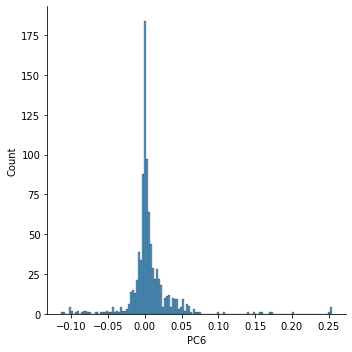

In [25]:
sns.displot(heatmap_df['PC6'])

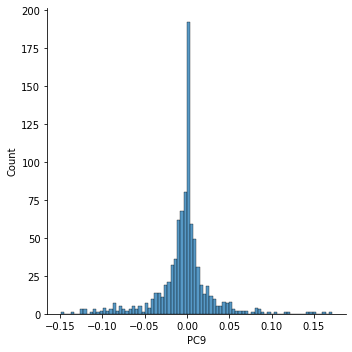

In [26]:
sns.displot(heatmap_df['PC9'])

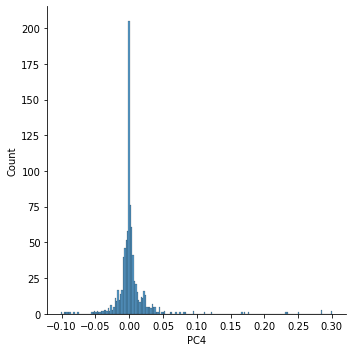

In [27]:
sns.displot(heatmap_df['PC4'])

In [28]:
for i in range(0, 100):
    pc_use = mad_ordered_PCs[i]
    PC_name = 'PC' + str(pc_use)
    SampleMeta[PC_name] = X_PCA[:, pc_use]

In [29]:
mad_ordered_PCs[0:20]

array([ 5,  6,  9,  4,  2, 12, 47, 13, 41, 52, 16, 42, 11, 29, 30, 27, 53,
       20, 31, 73])

<AxesSubplot:xlabel='PC5', ylabel='PC6'>

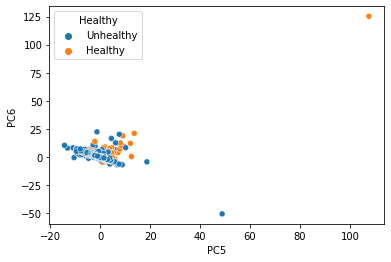

In [30]:
sns.scatterplot(data = SampleMeta, x = 'PC5', y = 'PC6', hue = 'Healthy')

<AxesSubplot:xlabel='PC9', ylabel='PC4'>

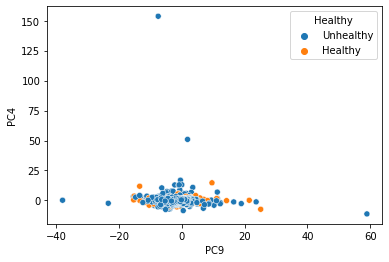

In [31]:
sns.scatterplot(data = SampleMeta, x = 'PC9', y = 'PC4', hue = 'Healthy')

<AxesSubplot:xlabel='PC2', ylabel='PC12'>

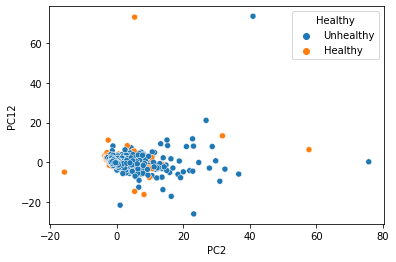

In [32]:
sns.scatterplot(data = SampleMeta, x = 'PC2', y = 'PC12', hue = 'Healthy')

In [33]:
healthy_inds = np.argwhere(SampleMeta['Healthy'].to_numpy() == 'Healthy')
unhealthy_inds = np.argwhere(SampleMeta['Healthy'].to_numpy() != 'Healthy')

In [34]:
t_test_results = {'PC': [], 't': [], 'p': []}
for x in mad_ordered_PCs[0:40]:
    pc_name = 'PC'+str(x)
    pc_vals = SampleMeta[pc_name].to_numpy().astype('float')
    t_test_result_x = stats.ttest_ind(pc_vals[healthy_inds], pc_vals[unhealthy_inds])
    t_test_results['PC'].append(pc_name)
    t_test_results['t'].append(t_test_result_x[0])
    t_test_results['p'].append(t_test_result_x[1])

In [35]:
t_test_results = pd.DataFrame(t_test_results)
t_test_results

,PC,t,p
0,PC5,[10.829797726489234],[5.4841478051680515e-27]
1,PC6,[-6.566046750453601],[5.774187759563588e-11]
2,PC9,[8.681256733922158],[5.453318678798592e-18]
3,PC4,[-4.432822660120945],[9.530132688490638e-06]
4,PC2,[-17.06400633827915],[3.0335290752900344e-63]
5,PC12,[4.652167271072596],[3.3823227238436403e-06]
6,PC47,[1.088109233712632],[0.2766072392454771]
7,PC13,[-1.839788083585054],[0.06586752993411586]
8,PC41,[-2.3001533898357223],[0.021486697425528993]
9,PC52,[6.525399418120427],[7.559114501989691e-11]


<AxesSubplot:xlabel='PC61', ylabel='PC64'>

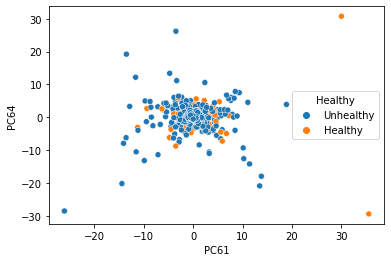

In [44]:
sns.scatterplot(data = SampleMeta, x = 'PC61', y = 'PC64', hue = 'Healthy')

<AxesSubplot:xlabel='PC151', ylabel='PC112'>

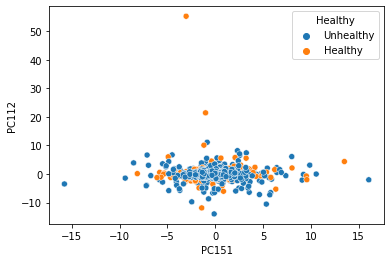

In [45]:
sns.scatterplot(data = SampleMeta, x = 'PC151', y = 'PC112', hue = 'Healthy')

<AxesSubplot:xlabel='PC151', ylabel='PC86'>

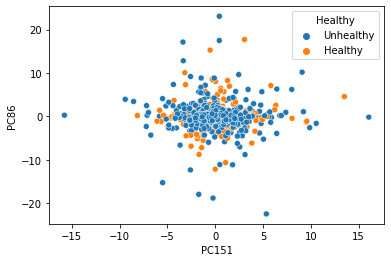

In [46]:
sns.scatterplot(data = SampleMeta, x = 'PC151', y = 'PC86', hue = 'Healthy')